In [65]:
# Part 1: Data Preprocessing [7 marks]
# Download the Term Marketing - Banking data set from the following link: https://www.kaggle.com/datasets/prakharrathi25/banking-dataset-marketing-targetsLinks to an external site.
# Clean and explore the data. Summarize your findings.
# Build a pipeline to process the data (i.e., One Hot Encoding, Scaling, and any other relevant transformations)
# Explain your pre-processing approach and justify the transformations you have made.
# Part 2: Build Baseline Models [3 marks]
# Create baseline models using logistic regression and k-NN. Tune the models.
# Evaluate these models using the performance metrics you deem appropriate.
# Part 3: Ensemble Modelling [6 marks]

# Random Forest

# Build a Random Forest model.
# Tune hyperparameters.
# AdaBoost

# Build an AdaBoost model.
# Tune hyperparameters.
#Bagging Classifier

#Build a Bagging Classifier with a base estimator of your choice.
#Tune hyperparameters.
#Voting Classifier

# Build a Voting Classifier using a mix of at least three different classification models.
# Experiment with both hard and soft voting.
# Part 4: Performance Comparison [4 marks]
# Compare the performance of all models (including the baseline models). Consider both the time required for the models to run, and the performance of the models on the data set.
# Part 5: Interpretation and Justification [8 marks]
# Why did the ensemble models perform the way they did?

#Beyond the hyperparameters, use your understanding of how the models work to explain why you think the models performed they way they did on the given data set. Was the result what you were expecting? Why or why not?
#If you had to pick one model to implement in business process, which would it be and why?

#Discuss the business implications.
#Consider not only performance metrics but also computational cost and interpretability.
#What decision criteria did you use to arrive at this conclusion?

#Precision-Recall trade-off? Computational cost? Others?
#Grammar and Spelling [2 marks]

# Import Libraries

In [66]:
# Import Libraries

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pylab as plt

import dmba
from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold #GridSearch is for hyperparameter tuning
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, FunctionTransformer, label_binarize
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score, accuracy_score, precision_score, recall_score, PrecisionRecallDisplay, RocCurveDisplay, make_scorer, mean_squared_error,classification_report,confusion_matrix,ConfusionMatrixDisplay, roc_curve, auc,roc_auc_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Part 1: Data Preprocessing

In [67]:
# Load the Dataset - requires delimeter parameter (data is divided with semi-colons, not commas)
df = pd.read_csv('https://raw.githubusercontent.com/EthanRosehart/DS2_Assignments/main/train.csv', delimiter=';')

In [68]:
# Check the data
df.head(10)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
5,35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
6,28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
7,42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
8,58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no
9,43,technician,single,secondary,no,593,yes,no,unknown,5,may,55,1,-1,0,unknown,no


Check for Missing Values & Data Types

In [69]:
# Check for missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Exploring the Data (Basic Descriptive Statistics)

In [70]:
# Get basic statistical summary for numerical columns
print("Statistical Summary for Numerical Columns:\n", df.describe())

# For categorical columns, let's see the unique values
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"Unique values in {col}:\n", df[col].value_counts())

Statistical Summary for Numerical Columns:
                 age        balance           day      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000

In [71]:
# Convert 'y' column into binary values: 1 for 'yes' and 0 for 'no'
df['y'] = df['y'].map({'yes': 1, 'no': 0})

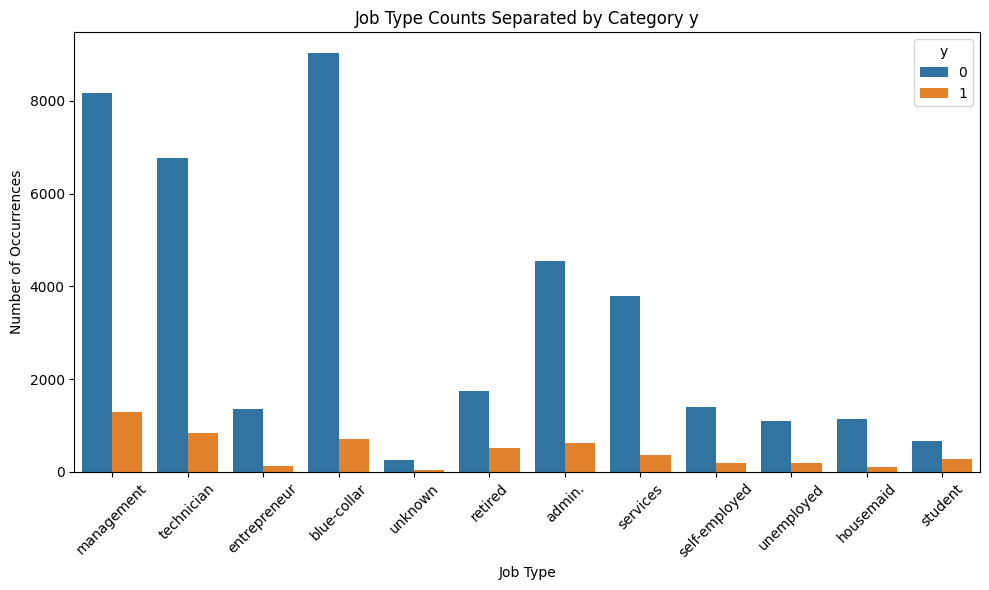

In [72]:
# Create a count plot with 'hue' for the 'y' column
plt.figure(figsize=(10,6))
sns.countplot(x='job', hue='y', data=df)

plt.title('Job Type Counts Separated by Category y')
plt.xlabel('Job Type')
plt.ylabel('Number of Occurrences')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

job
admin.           0.122027
blue-collar      0.072750
entrepreneur     0.082717
housemaid        0.087903
management       0.137556
retired          0.227915
self-employed    0.118429
services         0.088830
student          0.286780
technician       0.110570
unemployed       0.155027
unknown          0.118056
Name: y, dtype: float64


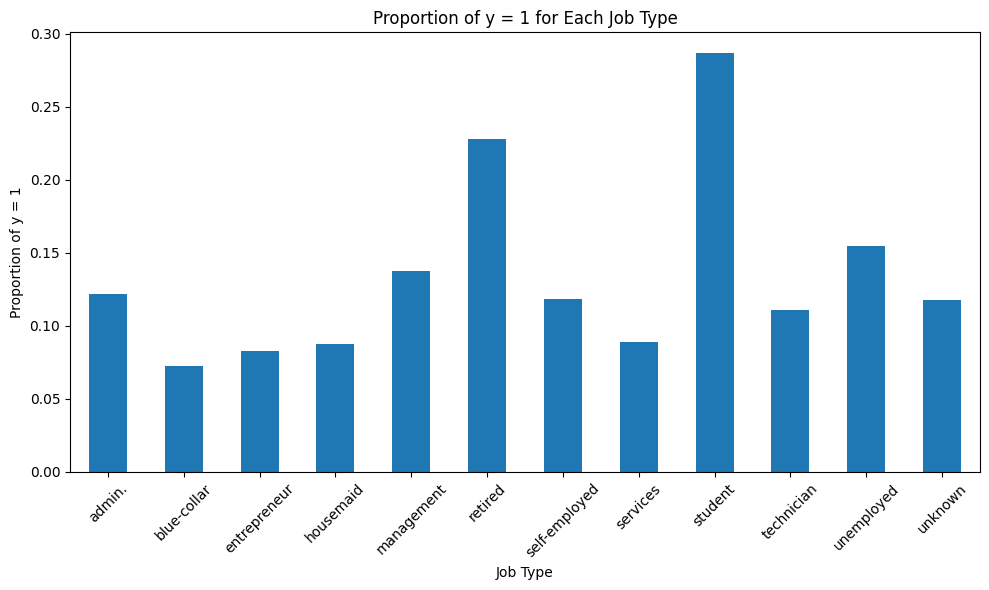

In [73]:
# Calculate the proportion of 'y = 1' for each job type
proportions = df.groupby('job')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Each Job Type')
plt.xlabel('Job Type')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

Possible positive relationship with Students and Retired

marital
divorced    0.119455
married     0.101235
single      0.149492
Name: y, dtype: float64


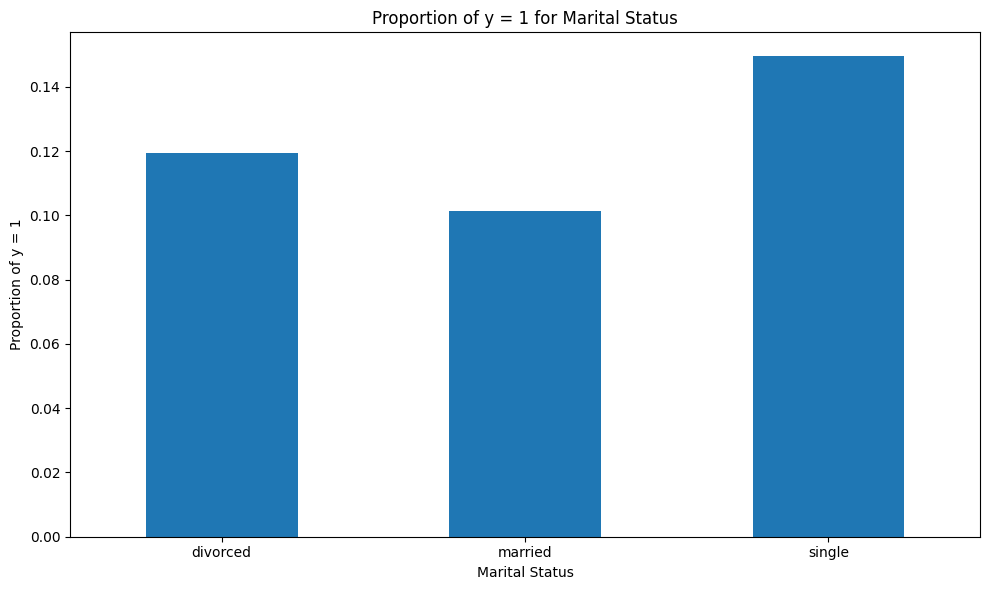

In [74]:
# Calculate the proportion of 'y = 1' for each job type
proportions = df.groupby('marital')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

Possible Positive Relationship with those that are NOT married

education
primary      0.086265
secondary    0.105594
tertiary     0.150064
unknown      0.135703
Name: y, dtype: float64


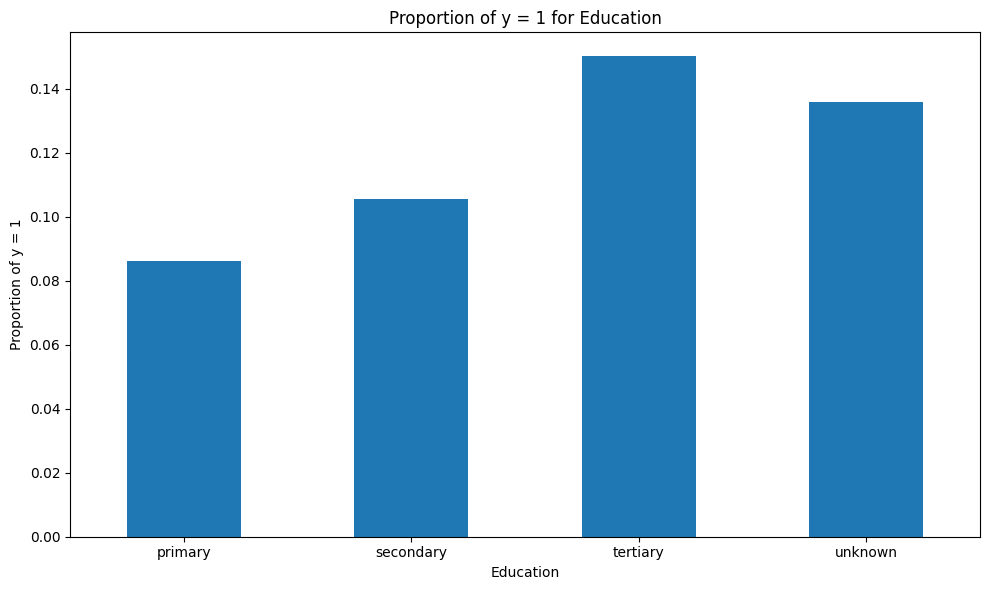

In [75]:
# Calculate the proportion of 'y = 1' for each job type
proportions = df.groupby('education')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Education')
plt.xlabel('Education')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

Possible positive relationship to y for those with tertiary education and unknown

housing
no     0.167024
yes    0.077000
Name: y, dtype: float64


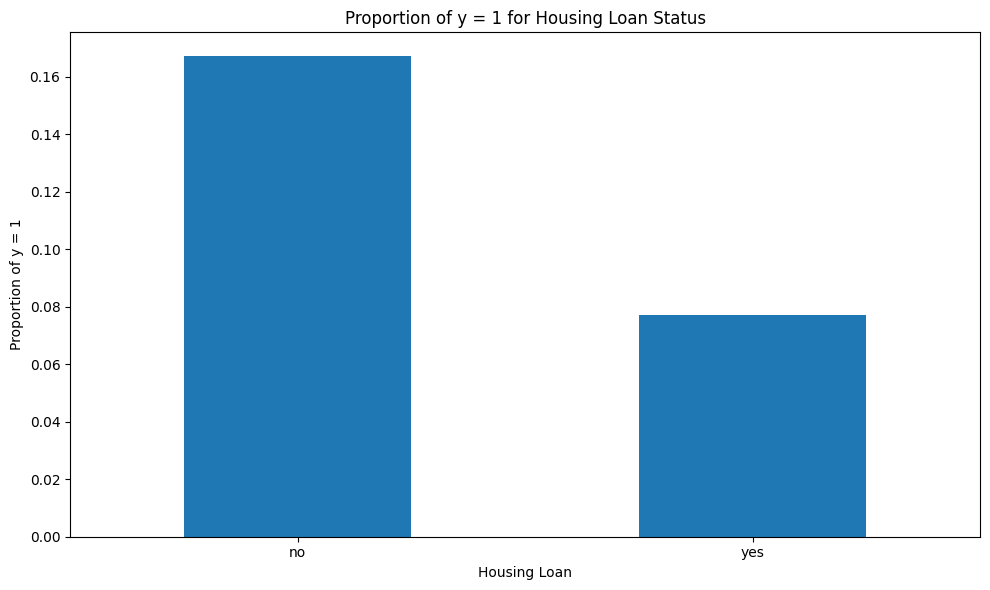

In [76]:
# Calculate the proportion of 'y = 1' for each job type
proportions = df.groupby('housing')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Housing Loan Status')
plt.xlabel('Housing Loan')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

This graph shows twice the liklihood of a successful customer who does NOT have a housing Loan

loan
no     0.126557
yes    0.066814
Name: y, dtype: float64


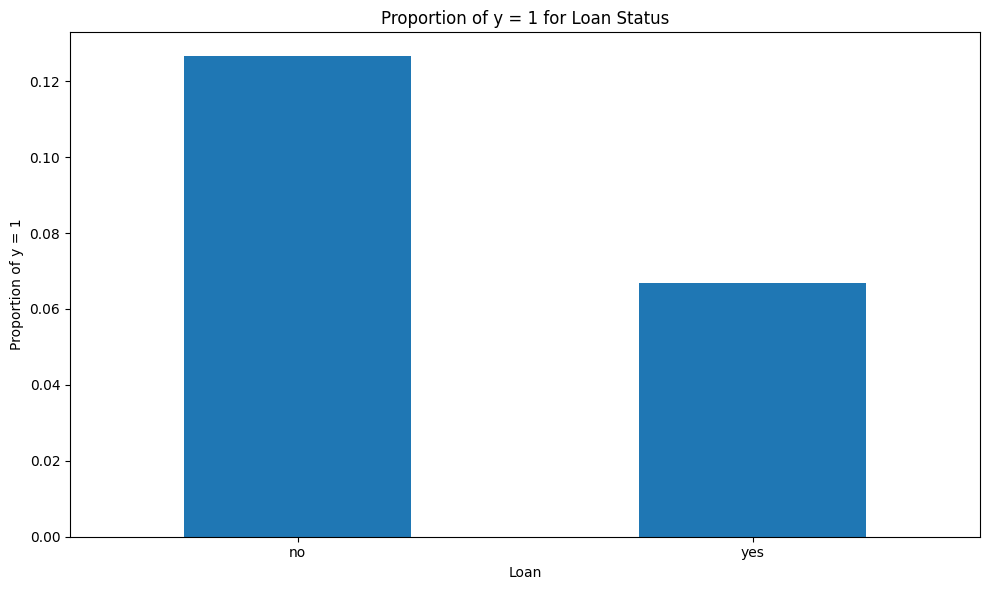

In [77]:
# Calculate the proportion of 'y = 1' for each job type
proportions = df.groupby('loan')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Loan Status')
plt.xlabel('Loan')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

Possible positive relationship those who do NOT have a loan more likely to say yes

default
no     0.117961
yes    0.063804
Name: y, dtype: float64


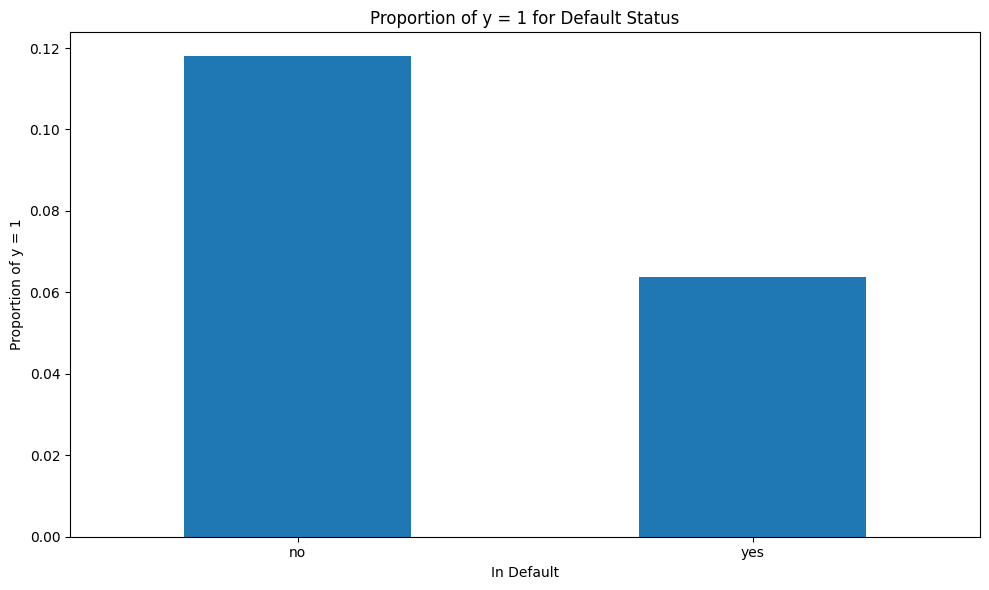

In [78]:
# Calculate the proportion of 'y = 1' for each job type
proportions = df.groupby('default')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Default Status')
plt.xlabel('In Default')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

those not in default more likely to say yes

poutcome
failure    0.126097
other      0.166848
success    0.647253
unknown    0.091615
Name: y, dtype: float64


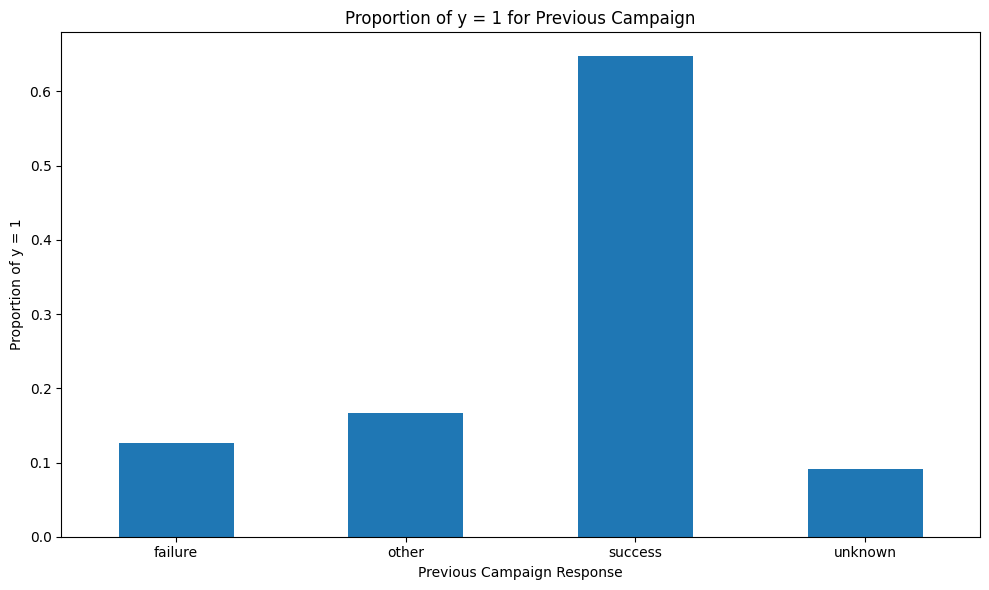

In [79]:
# Calculate the proportion of 'y = 1' for each job type
proportions = df.groupby('poutcome')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Previous Campaign')
plt.xlabel('Previous Campaign Response')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

Previous Campaign Success more likely to have success this time as well 64.7%

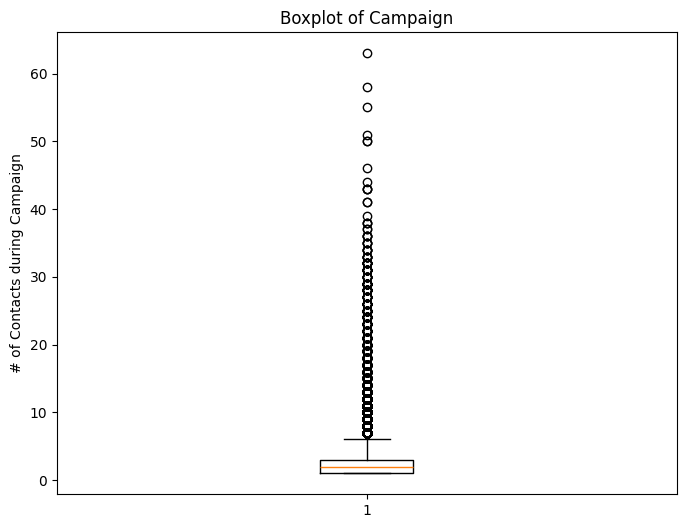

In [80]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['campaign'])
plt.title('Boxplot of Campaign')
plt.ylabel('# of Contacts during Campaign')
plt.show()

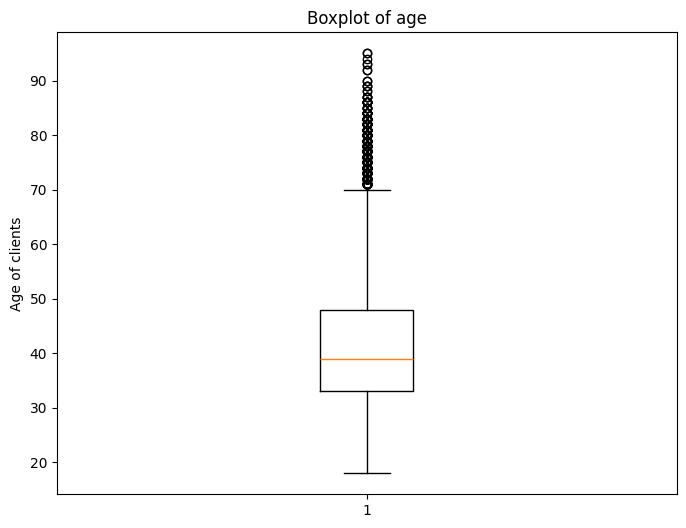

In [81]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['age'])
plt.title('Boxplot of age')
plt.ylabel('Age of clients')
plt.show()

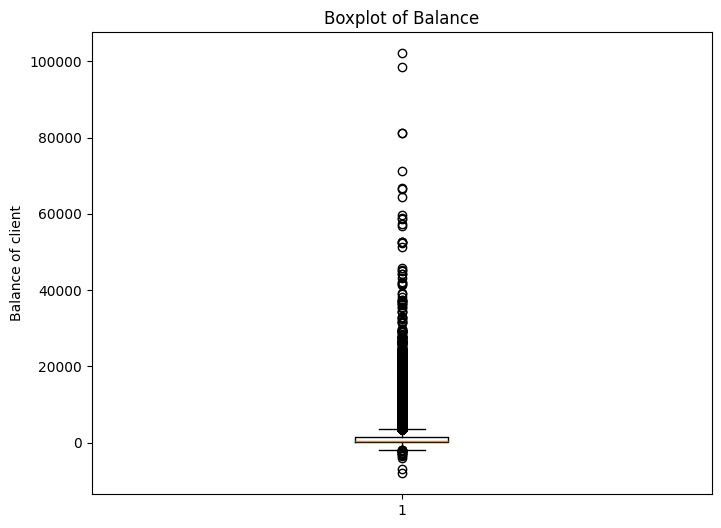

In [82]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['balance'])
plt.title('Boxplot of Balance')
plt.ylabel('Balance of client')
plt.show()

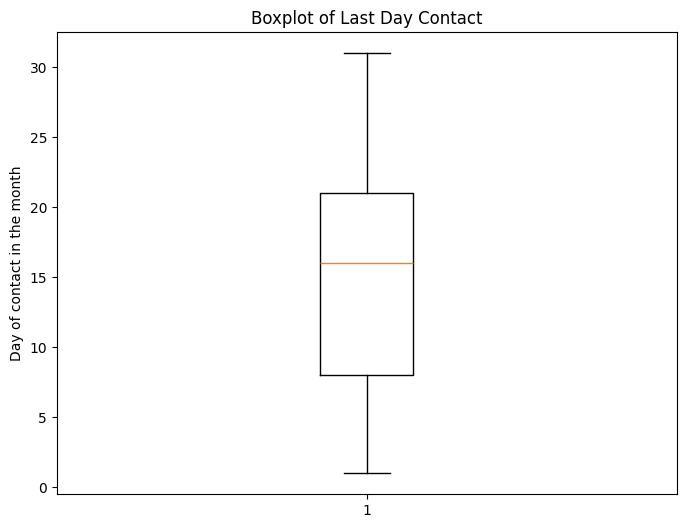

In [83]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['day'])
plt.title('Boxplot of Last Day Contact')
plt.ylabel('Day of contact in the month')
plt.show()

Handling Potential Outliers

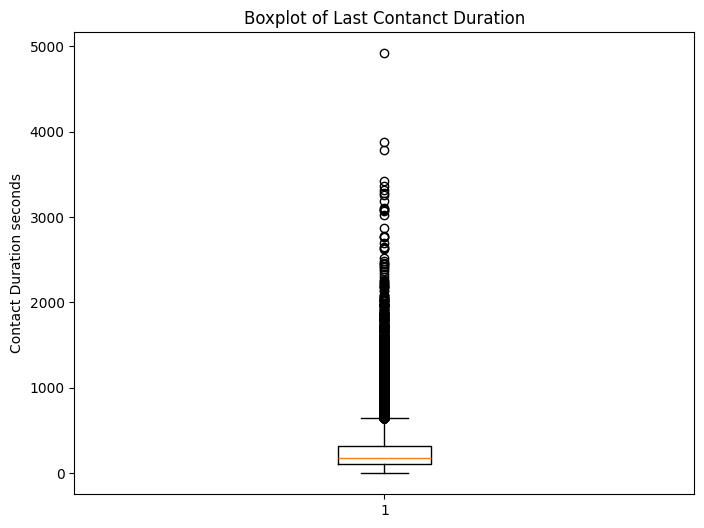

In [84]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['duration'])
plt.title('Boxplot of Last Contanct Duration')
plt.ylabel('Contact Duration seconds')
plt.show()

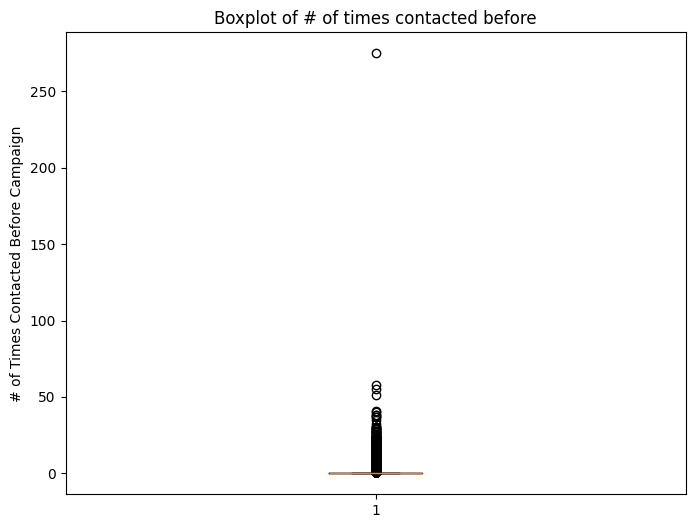

In [85]:
plt.figure(figsize=(8, 6))
plt.boxplot(df['previous'])
plt.title('Boxplot of # of times contacted before')
plt.ylabel('# of Times Contacted Before Campaign')
plt.show()

In [86]:
df['previous'].max()

275

Day wil be utilized as a categorical variable, while campaign, age, balance and duration will all be sorted in to bins. 
df['previous'] = 275 will be dropped as it is considered an extreme outlier. 


In [87]:
df['age'].describe()

count    45211.000000
mean        40.936210
std         10.618762
min         18.000000
25%         33.000000
50%         39.000000
75%         48.000000
max         95.000000
Name: age, dtype: float64

In [88]:
# FEATURE ENGINEERING

# Define the age bins and labels
bins = [18, 30, 40, 50, float('inf')]
labels = ['18-29', '30-39', '40-49', '50+']

# Create the age bins and label them
df['age_bins'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

df['age_bins'].value_counts()


age_bins
30-39    18089
40-49    11655
50+      10194
18-29     5273
Name: count, dtype: int64

age_bins
18-29    0.175991
30-39    0.105755
40-49    0.091205
50+      0.135864
Name: y, dtype: float64


C:\Users\Berry\AppData\Local\Temp\ipykernel_26224\988866204.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby('age_bins')['y'].mean()


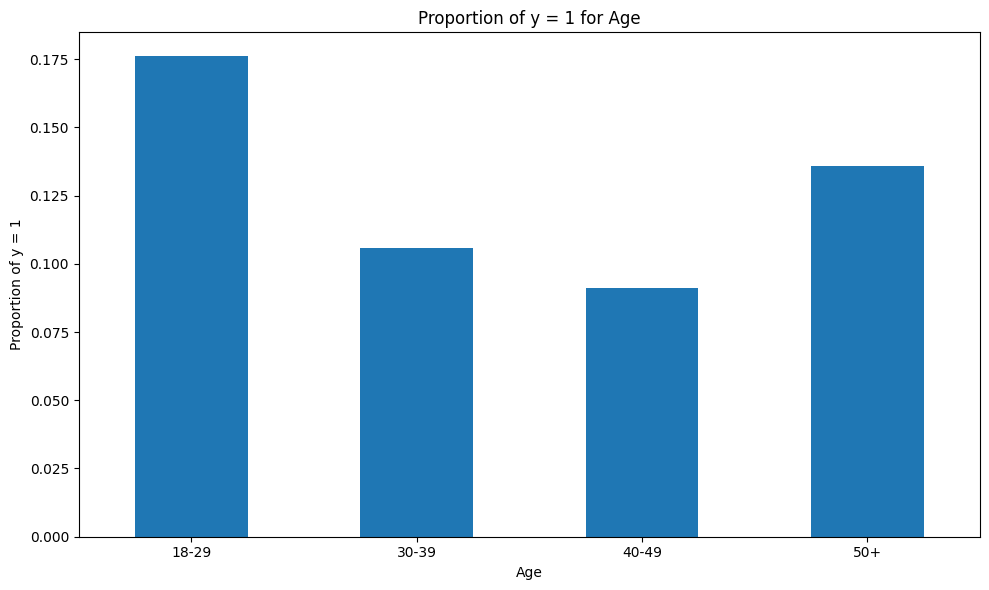

In [89]:
# Calculate the proportion of 'y = 1' for each age bin
proportions = df.groupby('age_bins')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Age')
plt.xlabel('Age')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

In [90]:
df['campaign'].describe()

count    45211.000000
mean         2.763841
std          3.098021
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         63.000000
Name: campaign, dtype: float64

In [91]:
# Define the campaign bins and labels
bins = [1, 2, 3, 4, float('inf')]  
labels = ['1', '2', '3', '4+']  

# Apply the cut function
df['campaign_bins'] = pd.cut(df['campaign'], bins=bins, labels=labels, right=False)

# Check the results
df['campaign_bins'].value_counts()

campaign_bins
1     17544
2     12505
4+     9641
3      5521
Name: count, dtype: int64

campaign_bins
1     0.145976
2     0.112035
3     0.111936
4+    0.073540
Name: y, dtype: float64


C:\Users\Berry\AppData\Local\Temp\ipykernel_26224\2183000875.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby('campaign_bins')['y'].mean()


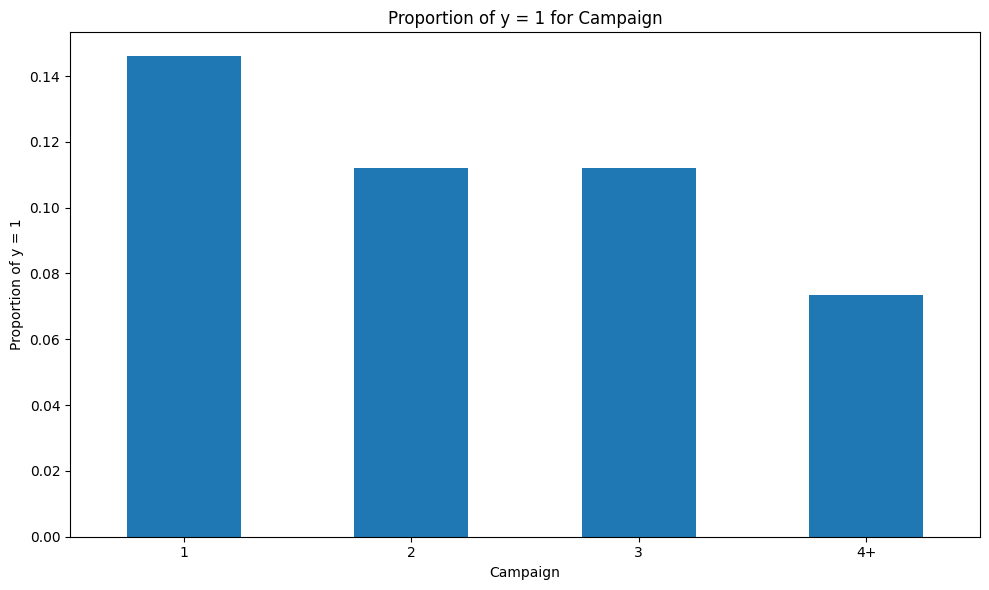

In [92]:
# Calculate the proportion of 'y = 1' for each campaign bin
proportions = df.groupby('campaign_bins')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Campaign')
plt.xlabel('Campaign')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

In [93]:
df['balance'].describe()

count     45211.000000
mean       1362.272058
std        3044.765829
min       -8019.000000
25%          72.000000
50%         448.000000
75%        1428.000000
max      102127.000000
Name: balance, dtype: float64

In [94]:
# Define the balance bins and labels
bins = [float('-inf'), 50, 450, 1450, float('inf')]
labels = ['<50', '50-449', '450-1449', '1450+']

# Create the balance bins and label them
df['balance_bins'] = pd.cut(df['balance'], bins=bins, labels=labels, right=False)

df['balance_bins'].value_counts()

balance_bins
50-449      12289
450-1449    11412
1450+       11175
<50         10335
Name: count, dtype: int64

balance_bins
<50         0.069860
50-449      0.107983
450-1449    0.125657
1450+       0.161611
Name: y, dtype: float64


C:\Users\Berry\AppData\Local\Temp\ipykernel_26224\2982822475.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby('balance_bins')['y'].mean()


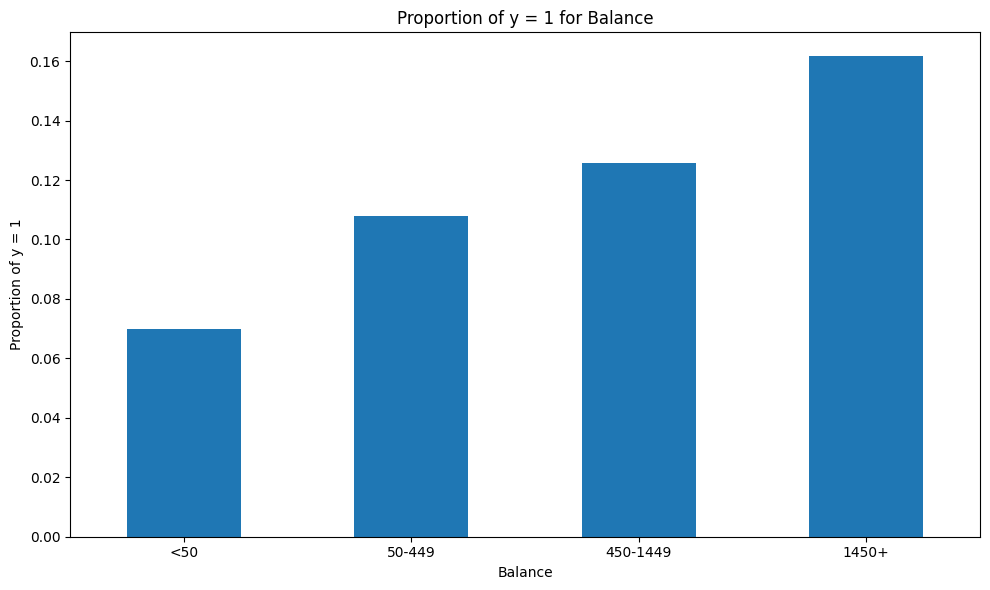

In [95]:
# Calculate the proportion of 'y = 1' for each balance bin
proportions = df.groupby('balance_bins')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Balance')
plt.xlabel('Balance')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

In [96]:
df['duration'].describe()

count    45211.000000
mean       258.163080
std        257.527812
min          0.000000
25%        103.000000
50%        180.000000
75%        319.000000
max       4918.000000
Name: duration, dtype: float64

In [97]:
# Define the duration bins and labels
bins = [0, 100, 180, 319, float('inf')]
labels = ['0-99', '100-179', '180-318', '319+']

# Create the duration bins and label them
df['duration_bins'] = pd.cut(df['duration'], bins=bins, labels=labels, right=False)

df['duration_bins'].value_counts()

duration_bins
100-179    11813
180-318    11360
319+       11314
0-99       10724
Name: count, dtype: int64

duration_bins
0-99       0.010537
100-179    0.049776
180-318    0.111444
319+       0.293619
Name: y, dtype: float64


C:\Users\Berry\AppData\Local\Temp\ipykernel_26224\1563500916.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  proportions = df.groupby('duration_bins')['y'].mean()


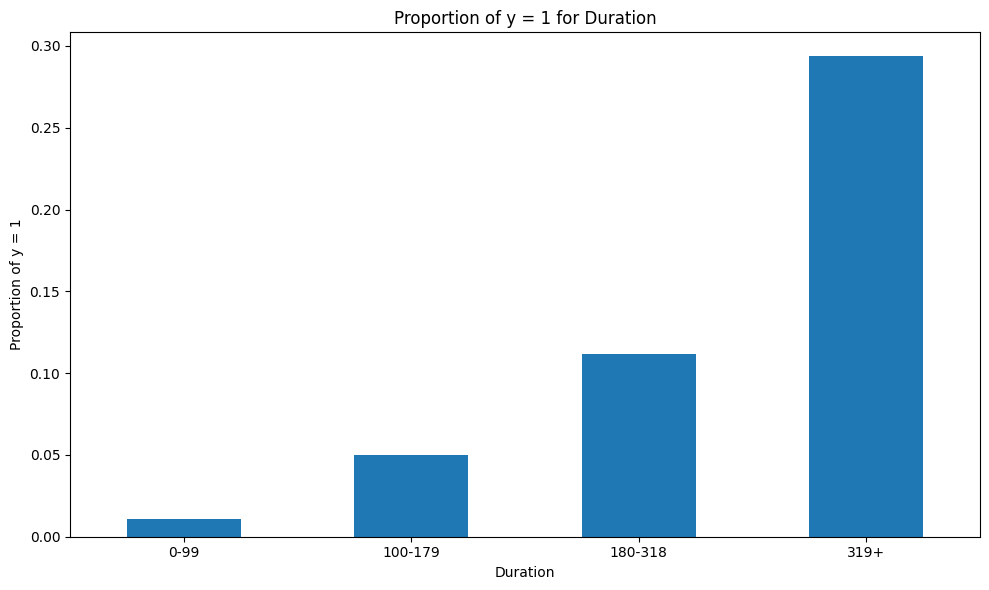

In [98]:
# Calculate the proportion of 'y = 1' for each duration bin
proportions = df.groupby('duration_bins')['y'].mean()

# Display the result
print(proportions)
# Create a bar plot
plt.figure(figsize=(10,6))
proportions.plot(kind='bar')

plt.title('Proportion of y = 1 for Duration')
plt.xlabel('Duration')
plt.ylabel('Proportion of y = 1')
plt.xticks(rotation=0)
plt.tight_layout()

# Show the plot
plt.show()

In [99]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y', 'age_bins', 'campaign_bins',
       'balance_bins', 'duration_bins'],
      dtype='object')

FOR CLARITY SAKE GURK WORK IS BELOW UNTIL STATED OTHERWISE. ( DELETE THIS BEFORE SUBMITTING ASSIGNMENT)

In [100]:
# Let's proceed with the data preprocessing steps, including One Hot Encoding for categorical variables and scaling the numeric variables.

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Seperating the categorical and numeric columns
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome'] # 'age_bins', 'campaign_bins', 'balance_bins', 'duration_bins'
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# OneHotEncoding for categorical columns and StandardScaler for numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ])

Note that in the original dataset "Y" refers to the response variable which is whether or not the client has subscribed to a term deposit. Reminder that this is how banks make a lot of their money. We take this info into consideration when creating the model and pipeline now that we have completed our EDA and transformations.

In [101]:
# Split the data into features and target
X = df.drop('y', axis=1)
y = df['y']

# Ensure stratified split to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Create a preprocessing pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])



In [102]:
X_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,age_bins,campaign_bins,balance_bins,duration_bins
24001,36,technician,divorced,secondary,no,861,no,no,telephone,29,aug,140,2,-1,0,unknown,30-39,2,450-1449,100-179
43409,24,student,single,secondary,no,4126,no,no,cellular,5,apr,907,4,185,7,failure,18-29,4+,1450+,319+
20669,44,technician,single,secondary,no,244,yes,no,cellular,12,aug,1735,4,-1,0,unknown,40-49,4+,50-449,319+
18810,48,unemployed,married,secondary,no,0,no,no,telephone,31,jul,35,11,-1,0,unknown,40-49,4+,<50,0-99
23130,38,technician,married,secondary,no,257,no,no,cellular,26,aug,57,10,-1,0,unknown,30-39,4+,50-449,0-99


In [103]:
# Fit the pipeline to the training data
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

# Display the processed features' shape
X_train_processed.shape, X_test_processed.shape

((36168, 51), (9043, 51))

In [104]:
#Here we check distribution of y value
y_balance = df['y'].value_counts()

# Display the balance of the classes
y_balance


y
0    39922
1     5289
Name: count, dtype: int64

As we can see from above the Y value is heavily imbalanced with more responses being negative (0) to the subscription than positive (1)

In [105]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set up the logistic regression model
logreg = LogisticRegression(max_iter=1000)

In [106]:
# Define hyperparameters to tune
param_grid = {'C': [0.1, 1.0, 10.0], 'penalty': ['l2'], 'solver': ['lbfgs', 'liblinear']}

# Perform grid search to find the best hyperparameters
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy')

# Fit the model on the preprocessed training data
logreg_cv.fit(X_train_processed, y_train)



GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1, 1.0, 10.0], 'penalty': ['l2'],
                         'solver': ['lbfgs', 'liblinear']},
             scoring='accuracy')

For these next 3 lines of code we are checking why we only have negative responses for the Y value and trying to rectify it and failing. (THIS SECTION WILL BE REMOVED BEFORE FINAL SUBMISSION JUST IGNORE FOR NOW).
The above error is telling us that we dont have 2 classifiers (1 or 0), the results below prove this is true. (THIS SECTION WILL BE REMOVED BEFORE FINAL SUBMISSION JUST IGNORE FOR NOW) this is just to show that we messed up and troubleshooted the issue.

In [107]:

# Check the distribution of 'y_train' 
print("y_train class distribution:", y_train.value_counts())


y_train class distribution: y
0    31937
1     4231
Name: count, dtype: int64


In [108]:
# Ensure stratified split to maintain class balance in both training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [109]:
# Check the overall distribution in the original target column 'y' again
print("Overall class distribution:", y.value_counts())


Overall class distribution: y
0    39922
1     5289
Name: count, dtype: int64


In [110]:
#Leaving this gap here after I fixed the sampling issue
#have to run this code below after reading a fresh csv file from Ethan's Github

#Everything below this point will definitely appear in the final report of the assignment because it shows how the sampling issue was resolved


In [111]:
# Convert the 'y' column from 'yes'/'no' to binary values (1 for 'yes', 0 for 'no')
df['y'] = df['y']

# Verify the encoding was successful by checking the distribution again
y_encoded_distribution = df['y'].value_counts()

# Split the data into features and target
X = df.drop('y', axis=1)  # X includes all features except the target 'y'
y = df['y']  # y is the binary encoded target variable

# Apply stratified train-test split to maintain class balance
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check the class distribution in y_train and y_test to ensure stratification worked
y_train_distribution = y_train.value_counts()
y_test_distribution = y_test.value_counts()

# Display the distributions for y_train and y_test
y_encoded_distribution, y_train_distribution, y_test_distribution


(y
 0    39922
 1     5289
 Name: count, dtype: int64,
 y
 0    31937
 1     4231
 Name: count, dtype: int64,
 y
 0    7985
 1    1058
 Name: count, dtype: int64)

The reason we stratify the dataset since we previously were having issues getting a proper proportion of yes and now values, this solves are issues and the display is shown above.

In [112]:
# Preprocess the categorical and numeric columns: One Hot Encoding for categorical and scaling for numeric
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [113]:
# Identify categorical and numeric columns
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

# Build a column transformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),   # Scaling for numeric columns
        ('cat', OneHotEncoder(), categorical_cols) # One Hot Encoding for categorical columns
    ])



In [114]:
# Fit and transform the training data, transform the test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Display the shape of the processed training and test sets
X_train_processed.shape, X_test_processed.shape

((36168, 51), (9043, 51))

The training set now has 36,168 samples and 51 features after applying One Hot Encoding and scaling.
The test set has 9,043 samples and 51 features.

In [115]:
# Display the distribution of 'y' in the training set after preprocessing to confirm class balance
y_train_distribution = y_train.value_counts()

# Display the distribution of 'y' in the testing set to ensure it's consistent with the training set
y_test_distribution = y_test.value_counts()

# Output the class distribution in y_train and y_test
y_train_distribution, y_test_distribution


(y
 0    31937
 1     4231
 Name: count, dtype: int64,
 y
 0    7985
 1    1058
 Name: count, dtype: int64)

Now that our fixed and edited Pipeline has been created and our preprocessing steps have been added to it we can go on to make our own baseline models.

In [116]:
# Import necessary libraries for models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Logistic Regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train_processed, y_train)

# Make predictions on the test set
y_pred_logreg = logreg.predict(X_test_processed)

# Evaluate Logistic Regression model
logreg_report = classification_report(y_test, y_pred_logreg)

In [117]:
# k-Nearest Neighbors model
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_processed, y_train)

# Make predictions on the test set
y_pred_knn = knn.predict(X_test_processed)

# Evaluate k-NN model
knn_report = classification_report(y_test, y_pred_knn)

In [118]:
print(logreg_report)
print(knn_report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.64      0.35      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      7985
           1       0.60      0.34      0.43      1058

    accuracy                           0.90      9043
   macro avg       0.76      0.66      0.69      9043
weighted avg       0.88      0.90      0.88      9043



Logistic Regression:
Precision (Class 0): 92%
Recall (Class 0): 97%
F1-Score (Class 0): 95%
Precision (Class 1): 64%
Recall (Class 1): 35%
F1-Score (Class 1): 45%
Accuracy: 90%
k-NN:
Precision (Class 0): 92%
Recall (Class 0): 97%
F1-Score (Class 0): 94%
Precision (Class 1): 60%
Recall (Class 1): 34%
F1-Score (Class 1): 43%
Accuracy: 90%

Both models perform similarly, with high accuracy but lower recall for class 1 (the positive class). This suggests that while the models are good at predicting the majority class (0), they struggle with identifying the minority class (1), which is typical for imbalanced datasets.

In [119]:
#We can do some tuning to this in order to create a better model

In [120]:
from sklearn.model_selection import GridSearchCV

# Logistic Regression: Define the parameter grid for tuning
logreg_param_grid = {
    'C': [0.1, 1, 10],  # Regularization strength
    'solver': ['lbfgs', 'liblinear']  # Different solvers for optimization
}

# Set up the GridSearchCV for Logistic Regression
logreg_cv = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), logreg_param_grid, cv=5, scoring='accuracy')
logreg_cv.fit(X_train_processed, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000, random_state=42),
             param_grid={'C': [0.1, 1, 10], 'solver': ['lbfgs', 'liblinear']},
             scoring='accuracy')

In [121]:
# Predict using the best Logistic Regression model
y_pred_logreg_tuned = logreg_cv.predict(X_test_processed)

In [122]:
# k-NN: Define the parameter grid for tuning
knn_param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Number of neighbors
    'metric': ['euclidean', 'manhattan']  # Different distance metrics
}

# Set up the GridSearchCV for k-NN
knn_cv = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring='accuracy')
knn_cv.fit(X_train_processed, y_train)

# Predict using the best k-NN model
y_pred_knn_tuned = knn_cv.predict(X_test_processed)

In [123]:
# Evaluate both tuned models
logreg_tuned_report = classification_report(y_test, y_pred_logreg_tuned)
knn_tuned_report = classification_report(y_test, y_pred_knn_tuned)

In [124]:
#Now we display the results of the 2 models with Logistic regression on top and KNN on bottom as well as the best parameters used for them
print(logreg_tuned_report)
print(knn_tuned_report)

print(logreg_cv.best_params_)
print(knn_cv.best_params_)

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.64      0.35      0.45      1058

    accuracy                           0.90      9043
   macro avg       0.78      0.66      0.70      9043
weighted avg       0.89      0.90      0.89      9043

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      7985
           1       0.63      0.28      0.39      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.63      0.67      9043
weighted avg       0.88      0.90      0.88      9043

{'C': 10, 'solver': 'lbfgs'}
{'metric': 'manhattan', 'n_neighbors': 7}


Here are the results from tuning both the Logistic Regression and k-NN models:


Observations:
Logistic Regression slightly outperforms k-NN in terms of both precision and recall for the minority class (1). However, both models show low recall for class 1, indicating that while the models are good at identifying class 0, they struggle to identify the minority class (1).
k-NN performs similarly to Logistic Regression but with lower recall for class 1.

Compared to the previous models before the hyper parameter tuning the models appear to perform slightly better in their recall and precision but the improvement is not very significant.

NOTES FOR THE FUTURE FOR THIS SECTION ABOVE

In this section write about how the precision and recall scores are improved and some other BS.
We could mention how these models suck ass for modeling unbalanced datasets which this definitely is.
Additionally if we wanted to we could use SMOTE techniques but idk that might take too long and is a pain in the ass

 WIP

Part 3: Ensemble Models

In [125]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report


In [126]:
#Random Forest Model with manual inputs for certain parameters
rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)

# Train the Random Forest model
rf_model.fit(X_train_processed, y_train)


RandomForestClassifier(max_depth=20, min_samples_split=5, n_estimators=200,
                       random_state=42)

In [127]:
# Making predictions on the test set
y_pred_rf = rf_model.predict(X_test_processed)

rf_report = classification_report(y_test, y_pred_rf)
print(rf_report)

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.68      0.38      0.49      1058

    accuracy                           0.91      9043
   macro avg       0.80      0.68      0.72      9043
weighted avg       0.89      0.91      0.89      9043



Precision (Class 0): 92% – The proportion of correctly identified negatives (Class 0) out of all predicted negatives.

Recall (Class 0): 98% – The proportion of actual negatives (Class 0) correctly identified.

Precision (Class 1): 68% – The proportion of correctly identified positives (Class 1) out of all predicted positives.

Recall (Class 1): 38% – The proportion of actual positives (Class 1) correctly identified.

Accuracy: 91% – The overall proportion of correctly classified instances.

Macro Average: Averaged precision, recall, and F1-score across both classes.

Weighted Average: Averages weighted by the number of instances in each class.

Summary:
The Random Forest model performs well for class 0 but struggles with class 1 due to the class imbalance.
The recall for class 1 is lower, meaning the model is missing a significant portion of positive instances.

Basically this model is also not that good because of the data imbalance

In [128]:
#Leaving this section here because we could continue to edit the parameters for the RF model.
#THIS IS A PLACEHOLDER CELL, REMOVE # BELOW AND CHANGE PARAMETERS 

# rf_model = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)
# rf_model.fit(X_train_processed, y_train)

#y_pred_rf = rf_model.predict(X_test_processed)
#rf_report = classification_report(y_test, y_pred_rf)

#print(rf_report)


In [129]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report

In [130]:
# Defining the AdaBoost model
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)

# Training the AdaBoost model
ada_model.fit(X_train_processed, y_train)

C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(n_estimators=100, random_state=42)

In [131]:
# Make predictions on the test set
y_pred_ada = ada_model.predict(X_test_processed)

# Evaluate the AdaBoost model
ada_report = classification_report(y_test, y_pred_ada)

In [132]:
print(ada_report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.62      0.38      0.47      1058

    accuracy                           0.90      9043
   macro avg       0.77      0.67      0.71      9043
weighted avg       0.89      0.90      0.89      9043



Summary:
AdaBoost performs well overall but, like the other models, struggles with recall for class 1, meaning it's not capturing many true positives.
The accuracy is high, but class imbalance affects the ability to detect class 1.


Comparison with Other Models:
Random Forest performed better in terms of precision (68%) and recall (38%) for class 1, whereas AdaBoost has lower precision and similar recall for class 1.
Logistic Regression had slightly better precision for class 1 but similar recall compared to AdaBoost.

In [133]:
#Leaving this section here because we could continue to edit the parameters for the AdaBoost model.
#THIS IS A PLACEHOLDER CELL, REMOVE # BELOW AND CHANGE PARAMETERS or add more depending on what you want. Just play around with it
#Note you have to run all the code again below

ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)
ada_model.fit(X_train_processed, y_train)

y_pred_ada = ada_model.predict(X_test_processed)
ada_report = classification_report(y_test, y_pred_ada)

print(ada_report)

#Website for documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html

In [134]:
#Bagging Classifier

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report


In [135]:
# Define the base estimator (Decision Tree) for the Bagging Classifier 
# This allows us to edit it more easily later if needed
base_estimator = DecisionTreeClassifier(max_depth=10, random_state=42)

In [136]:
# Define the Bagging Classifier with the base estimator
bagging_model = BaggingClassifier(estimator=base_estimator, n_estimators=100, max_samples=0.8, max_features=1, random_state=42)

# Train the Bagging Classifier
bagging_model.fit(X_train_processed, y_train)

#Predictions on test sample
y_pred_bagging = bagging_model.predict(X_test_processed)

# Evaluating Bagging Classifier
bagging_report = classification_report(y_test, y_pred_bagging)

# Display the classification report
print(bagging_report)

              precision    recall  f1-score   support

           0       0.88      1.00      0.94      7985
           1       0.00      0.00      0.00      1058

    accuracy                           0.88      9043
   macro avg       0.44      0.50      0.47      9043
weighted avg       0.78      0.88      0.83      9043



C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Berry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classificati

Results:
Precision (Class 0): 88%
Recall (Class 0): 100% (almost all negatives are correctly predicted)
Precision (Class 1): 0% (the model predicts no positive cases)
Recall (Class 1): 0% (the model is not identifying any true positives)
Accuracy: 88% (driven entirely by correct classification of the majority class, 0)
Key Observations:
The Bagging Classifier is overfitting to the majority class (0), predicting all instances as 0. This is why it has a perfect recall for class 0, but it's failing to identify any of the minority class (1).
The macro average and weighted average f1-scores are low, reflecting the imbalance and the model's inability to classify class 1.

As we can see above this is not ideal and the model does not seem to be performing well so we can make some further edits to the parameters to try and improve the model.

In [137]:
# Define the Bagging Classifier with the base estimator
bagging_model = BaggingClassifier(estimator=base_estimator, n_estimators=100, max_samples = 0.9, max_features=0.9, random_state=42)

# Train the Bagging Classifier
bagging_model.fit(X_train_processed, y_train)

#Predictions on test sample
y_pred_bagging = bagging_model.predict(X_test_processed)

# Evaluating Bagging Classifier
bagging_report = classification_report(y_test, y_pred_bagging)

# Display the classification report
print(bagging_report)

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      7985
           1       0.66      0.38      0.48      1058

    accuracy                           0.90      9043
   macro avg       0.79      0.68      0.71      9043
weighted avg       0.89      0.90      0.89      9043



max_samples=0.9: This means that each base estimator in the bagging model is trained on 90% of the available training data. This can help reduce overfitting while allowing each estimator to capture sufficient data variance.
max_features=0.9: This means that each base estimator is trained on 90% of the available features, which adds additional randomness and helps prevent overfitting.
These adjustments likely improved the model's ability to generalize, leading to better results for class 1.

Comparision with older Bagging model
Key Insights:
Precision (Class 1): 66% — This is a significant improvement from earlier iterations.
Recall (Class 1): 38% — The model is now capturing more positive cases, but there's still room for improvement.
F1-Score (Class 1): 48% — The balance between precision and recall for class 1 is improving.
Overall Accuracy: 90%
Comparison:
The Bagging Classifier now performs better, especially for class 1, compared to previous results. The adjustments to max_samples and max_features have clearly improved the model's ability to generalize.
The model still has lower recall for class 1, but precision has increased, which indicates it's more confident when predicting positives, though some positives are still being missed.

In [138]:
#Voting Classifier

WIP

I have no clue if the stuff below is the correct way to do it I couldn't figure this out and just GPT's it. I've pasted the interpretation of this below the code.

In [139]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report

# Reuse the Logistic Regression, Random Forest, and Bagging Classifier models
logreg = LogisticRegression(C=10, solver='lbfgs', max_iter=1000, random_state=42)
rf = RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42)
# Bagging Classifier with a decision tree as the base estimator
from sklearn.tree import DecisionTreeClassifier
bagging_model = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=10, random_state=42),
    n_estimators=100,
    max_samples=0.9,
    max_features=0.9,
    random_state=42
)

# Build the Voting Classifier with hard voting
voting_clf_hard = VotingClassifier(estimators=[
    ('logreg', logreg), 
    ('rf', rf), 
    ('bagging', bagging_model)
], voting='hard')

# Train the hard voting classifier
voting_clf_hard.fit(X_train_processed, y_train)

# Make predictions and evaluate the hard voting classifier
y_pred_voting_hard = voting_clf_hard.predict(X_test_processed)
hard_voting_report = classification_report(y_test, y_pred_voting_hard)

print("Hard Voting Classifier Report:\n")
print(hard_voting_report)

# Build the Voting Classifier with soft voting (note: all models need to support predict_proba for soft voting)
voting_clf_soft = VotingClassifier(estimators=[
    ('logreg', logreg), 
    ('rf', rf), 
    ('bagging', bagging_model)
], voting='soft')

# Train the soft voting classifier
voting_clf_soft.fit(X_train_processed, y_train)

# Make predictions and evaluate the soft voting classifier
y_pred_voting_soft = voting_clf_soft.predict(X_test_processed)
soft_voting_report = classification_report(y_test, y_pred_voting_soft)

print("\nSoft Voting Classifier Report:\n")
print(soft_voting_report)


Hard Voting Classifier Report:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.67      0.38      0.48      1058

    accuracy                           0.91      9043
   macro avg       0.80      0.68      0.72      9043
weighted avg       0.89      0.91      0.89      9043


Soft Voting Classifier Report:

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      7985
           1       0.67      0.37      0.48      1058

    accuracy                           0.90      9043
   macro avg       0.79      0.67      0.71      9043
weighted avg       0.89      0.90      0.89      9043



Key Observations:
Hard and Soft Voting: Both hard and soft voting classifiers produced similar results. The precision for class 1 (positive class) is stable at 67%, but the recall is still relatively low, around 37-38%.
Accuracy: The overall accuracy for both models is similar (90-91%).
F1-Score for Class 1: The F1-Score for the minority class is the same in both cases (48%).
Conclusion:
Both hard and soft voting classifiers are performing similarly, with soft voting showing slightly lower recall but still maintaining overall performance in terms of precision, recall, and accuracy.

-- Gurk's work is done for now. This marks the end of the section I worked on.

In [ ]:
# Absolute Bull shit